# Programming a U-NET network.


U-NET (hourglass architecture with skip connections) is a neural network model dedicated to Computer Vision tasks and more specifically to semantic segmentation problems.

>**Encoder Diagram**
<center><img src="https://miro.medium.com/max/1400/1*xbG7s8urH-QcsHokMsj85Q.png" alt="Drawing" width="600px"/></center>

>**Decoder Diagram**
<center><img src="https://miro.medium.com/max/1400/1*LDJ4y5QJc_eCr7quukcKkg.png" alt="Drawing" width="600px"/></center>


We implement a U-Net model that fits the specifications in the diagram above and train it on the *Oxford Pets* dataset.

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-qantlk50
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-qantlk50
  Resolved https://github.com/tensorflow/examples.git to commit f2b560e341ee0b21f1b8a0f351077a656fff7336
  Preparing metadata (setup.py) ... done


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

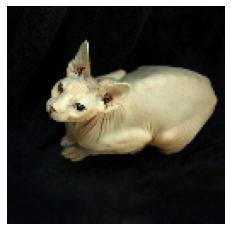

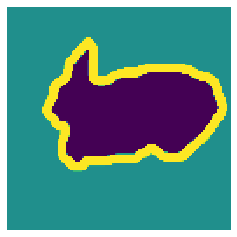

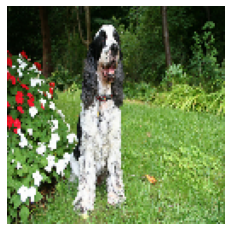

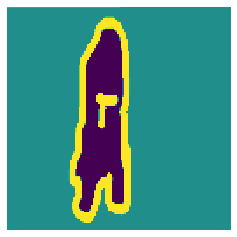

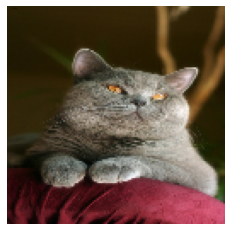

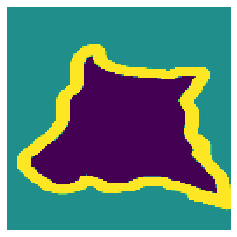

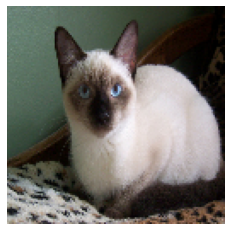

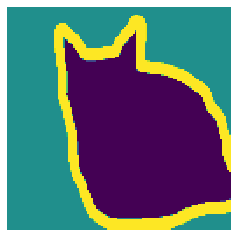

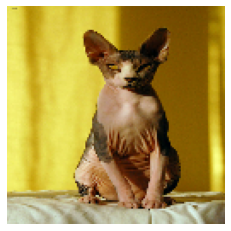

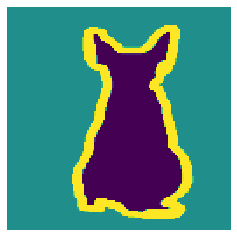

In [ ]:
IMG_SHAPE  = 128
BATCH_SIZE = 32

# Method that will process the dataset images and masks
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (IMG_SHAPE, IMG_SHAPE))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SHAPE, IMG_SHAPE))
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1

  return input_image, input_mask

# Process each datapoint with the method defined above
train_images = dataset['train'].map(load_image).batch(BATCH_SIZE)
test_images  = dataset['test'].map(load_image).batch(BATCH_SIZE)

# Visualize the loaded images
for images, masks in train_images.take(1):
  for i in range(5):
    plt.imshow(tf.keras.utils.array_to_img(images[i]))
    plt.axis('off')
    plt.show()
    plt.matshow(tf.keras.utils.array_to_img(masks[i]))
    plt.axis('off')
    plt.show()

In [ ]:
from tensorflow.keras import *
from tensorflow.keras.layers import * 
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.callbacks import EarlyStopping

size = 128

inpE = Input(shape=(size, size, 3))

def mini_block_encoder(n_filters, input):
  enc_1 = Conv2D(filters=n_filters, kernel_size=3, padding="same", activation="relu")(inpE)
  enc_2 = Conv2D(filters=n_filters, kernel_size=3, padding="same", activation="relu")(enc_1)
  enc_3 = MaxPooling2D()(enc_2)

  return enc_3, enc_2, enc_1


s1_enc, s2_enc, s3_enc = mini_block_encoder(16, inpE)

def mini_block_decoder(n_filters, skip_con1, s2_enc, s3_enc):
  dec_1 = Conv2DTranspose(filters=n_filters, kernel_size=3, padding="same", strides=2, activation='relu')(skip_con1)
  con_1 = concatenate([s2_enc, dec_1])
  dec_2 = Conv2D(filters=n_filters, kernel_size=3, padding="same", activation="relu")(con_1)
  con_2 = concatenate([s3_enc, dec_2])
  dec_3 = Conv2D(filters=n_filters, kernel_size=3, padding="same", activation="relu")(con_2)

  return dec_3

dec_f = mini_block_decoder(32, s1_enc, s2_enc, s3_enc)

model = Model(inputs=inpE, outputs=dec_f)

early_stop = EarlyStopping(monitor="val_acc", patience=5)

model.compile(Adam(), loss=SparseCategoricalCrossentropy(), metrics=["acc"])
model.fit(train_images, validation_data=test_images, epochs=20, callbacks=[early_stop])

Epoch 1/20
115/115 [==============================] - 28s 225ms/step - loss: 1.2468 - acc: 0.5468 - val_loss: 0.8836 - val_acc: 0.5731
Epoch 2/20
115/115 [==============================] - 26s 223ms/step - loss: 0.8170 - acc: 0.6035 - val_loss: 0.7868 - val_acc: 0.6214
Epoch 3/20
115/115 [==============================] - 26s 227ms/step - loss: 0.7755 - acc: 0.6370 - val_loss: 0.7527 - val_acc: 0.6570
Epoch 4/20
115/115 [==============================] - 34s 299ms/step - loss: 0.7427 - acc: 0.6583 - val_loss: 0.7395 - val_acc: 0.6677
Epoch 5/20
115/115 [==============================] - 34s 299ms/step - loss: 0.7361 - acc: 0.6651 - val_loss: 0.7466 - val_acc: 0.6700
Epoch 6/20
115/115 [==============================] - 35s 307ms/step - loss: 0.7151 - acc: 0.6755 - val_loss: 0.7052 - val_acc: 0.6853
Epoch 7/20
115/115 [==============================] - 34s 298ms/step - loss: 0.7072 - acc: 0.6796 - val_loss: 0.7044 - val_acc: 0.6863
Epoch 8/20
115/115 [==============================] - 3

In [ ]:
np.argmax(model.predict(test_images.take(1)), axis=3).shape

1/1 [==============================] - 0s 278ms/step


(32, 128, 128)

1/1 [==============================] - 0s 203ms/step


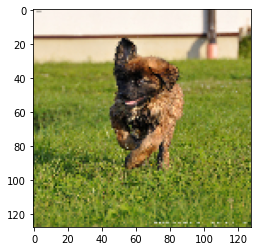

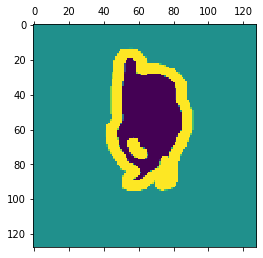

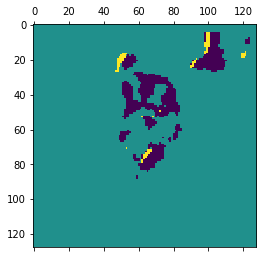

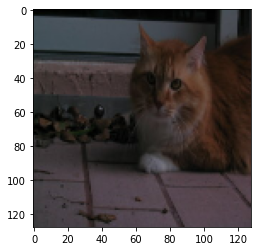

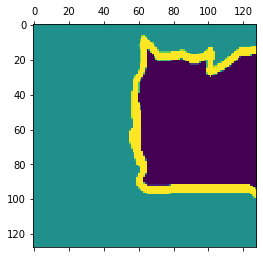

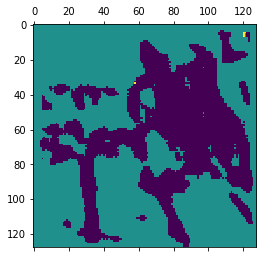

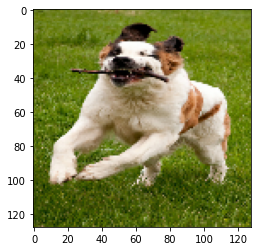

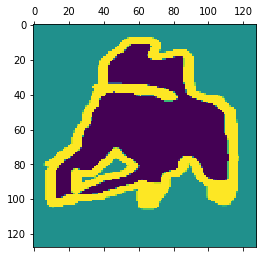

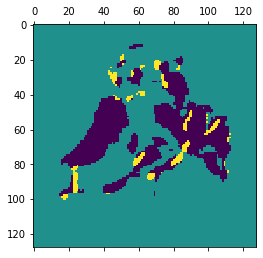

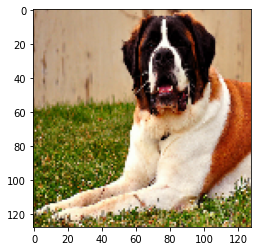

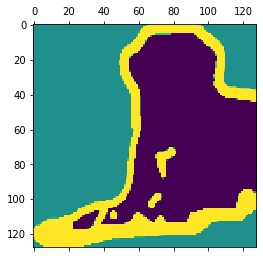

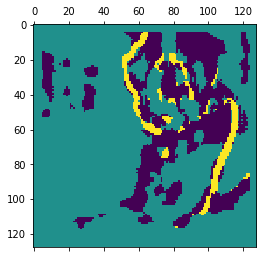

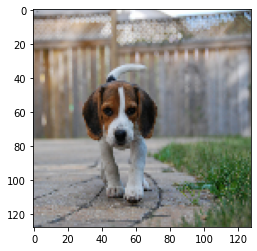

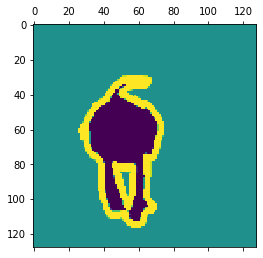

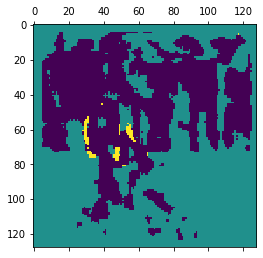

In [ ]:
input_images = test_images.take(1)
output_images = model.predict(input_images)

for images, masks in input_images:
  for i in range(5):
    plt.imshow(images[i])
    plt.show()
    plt.matshow(masks[i,:,:,0])
    plt.show()
    plt.matshow(np.argmax(output_images[i], axis=2))
    plt.show()